## preparar la base de datos

In [1]:
# código funciona perfectamente
import os
import csv

def cargar_lineas_validas(csv_path, salto=34):
    lineas = []
    with open(csv_path, 'r', encoding='utf-8', errors='ignore') as f:
        for i, line in enumerate(f):
            if i >= salto:
                if line.strip() == "":
                    break
                lineas.append(line.strip())
    return lineas

def encontrar_ruta_componente(archivo, dirs_prioridad):
    for d in dirs_prioridad:
        posible = os.path.join(d, archivo)
        if os.path.exists(posible):
            return posible
    return None

def procesar_vs30(tipo, magnitud, vs30, vs30_path, registros_validos):
    componentes = {
        "H1": os.path.join(vs30_path, "Componente Horizontal 1"),
        "H2": os.path.join(vs30_path, "Componente Horizontal 2"),
        "V":  os.path.join(vs30_path, "Componente Vertical")
    }
    search_csv = os.path.join(vs30_path, "_SearchResults.csv")
    if not os.path.isfile(search_csv):
        print(f"⚠️ No se encuentra el archivo CSV: {search_csv}")
        return 0

    lineas = cargar_lineas_validas(search_csv)
    if not lineas:
        print(f"⚠️ No se encontraron líneas válidas en el CSV: {search_csv}")
        return 0

    validos = 0
    for linea in lineas:
        row = linea.split(",")
        if len(row) < 3:
            continue
        arch_h1, arch_h2, arch_v = row[-3].strip(), row[-2].strip(), row[-1].strip()
        ruta_h1 = encontrar_ruta_componente(arch_h1, [componentes["H1"], componentes["H2"], componentes["V"]])
        ruta_h2 = encontrar_ruta_componente(arch_h2, [componentes["H2"], componentes["H1"]])
        ruta_v  = encontrar_ruta_componente(arch_v,  [componentes["V"],  componentes["H1"], componentes["H2"]])
        
        if ruta_h1 and ruta_h2 and ruta_v:
            validos += 1
            registros_validos.append({
                "Tipo de evento": tipo,
                "Magnitud": magnitud,
                "Vs30": vs30,
                "Archivo H1": arch_h1,
                "Ruta H1": ruta_h1,
                "Archivo H2": arch_h2,
                "Ruta H2": ruta_h2,
                "Archivo V": arch_v,
                "Ruta V": ruta_v
            })
        else:
            print("❌ Faltan archivos:", end=" ")
            if not ruta_h1: print("H1", end=" ")
            if not ruta_h2: print("H2", end=" ")
            if not ruta_v:  print("V",  end=" ")
            print(f"→ en {vs30_path}")
    return validos

def contar_eventos_validos_y_guardar_csv(base_path, tipos_evento, archivo_salida="eventos_validos.csv"):
    total_global = 0
    registros_validos = []

    for tipo in tipos_evento:
        tipo_path = os.path.join(base_path, tipo)
        if not os.path.isdir(tipo_path):
            print(f"❌ No existe la carpeta de tipo: {tipo_path}")
            continue

        for magnitud in os.listdir(tipo_path):
            mag_path = os.path.join(tipo_path, magnitud)
            if not os.path.isdir(mag_path):
                continue

            for vs30 in os.listdir(mag_path):
                vs30_path = os.path.join(mag_path, vs30)
                if not os.path.isdir(vs30_path):
                    continue

                total_local = procesar_vs30(tipo, magnitud, vs30, vs30_path, registros_validos)
                total_global += total_local

                estado = "✅" if total_local > 0 else "⚠️"
                print(f"📁 {tipo} | {magnitud} | {vs30} → {estado} {total_local} eventos válidos")

    # Guardar CSV
    if registros_validos:
        campos = list(registros_validos[0].keys())
        with open(archivo_salida, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=campos)
            writer.writeheader()
            writer.writerows(registros_validos)
        print(f"\n📄 Archivo CSV generado: {archivo_salida}")
    else:
        print("\n⚠️ No se generó ningún registro válido, no se creó el CSV.")

    return total_global

# Ejecutar
base_dir = os.path.join(os.getcwd(), "Base-sismos-2024")
tipos = ["1 Stiker Slip (SS)", "2 Normal-Oblique", "3 Reverse-Oblique"]
total = contar_eventos_validos_y_guardar_csv(base_dir, tipos)
print("\n🎯 TOTAL GLOBAL de eventos válidos con los tres componentes:", total)


❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 200-400
❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 200-400
❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 200-400
📁 1 Stiker Slip (SS) | Mag. 4-6 | Vs30. 200-400 → ✅ 97 eventos válidos
❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 400-600
❌ Faltan archivos: V → en /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/Base-sismos-2024/1 Stiker Slip (SS)/Mag. 4-6/Vs30. 400-600
📁 1 Stiker Slip (SS) | Mag. 4-6 | Vs30. 400-600 → ✅ 98 eventos válidos
📁 1 Stiker Slip (SS) | Mag. 4-6 | Vs30. 0-200 → ✅ 40 eventos válidos
❌ Faltan 

In [2]:
import pandas as pd

In [3]:
df_completo = pd.read_csv('eventos_validos.csv', encoding='utf-8')

In [4]:
# Creación del ID
import pandas as pd
import numpy as np
ph1=df_completo['Archivo H1'].str.split('_').str[:2].str.join('_')
ph2=df_completo['Archivo H2'].str.split('_').str[:2].str.join('_')
phv=df_completo['Archivo V'].str.split('_').str[:2].str.join('_')

mascara = (ph1 == ph2) & (ph1 == phv)
df_completo.loc[mascara, 'Evento ID'] = ph1[mascara]
columnas = ['Evento ID']+ [c for c in df_completo.columns if c != 'Evento ID']
df_completo = df_completo[columnas] #Reordenar, luego esto se lo meteria en el codigo de Andres para que eeste mas clean

#Nose como funciono esto, pero chat ayudo
ocurrencias = df_completo.groupby('Evento ID').cumcount()
mask_segundas = ocurrencias == 1

# 3) Renombra sólo esas filas, añadiendo "_2" al final
df_completo.loc[mask_segundas, 'Evento ID'] = (
    df_completo.loc[mask_segundas, 'Evento ID'] + '_2'
)

df_completo['Evento ID'].nunique()
df_completo.to_csv('eventos_actualizado.csv', index=False) #OJO A LOS NOMBRES DE ARCHIVO


In [5]:
# Creo que tiene ya todo junto
import re

def processNGAfile3(filepath, scalefactor=None):
    """
    Lee un .AT2 y devuelve (npts, dt, time, inp_acc), buscando dinámicamente
    la línea con NPTS= y DT=, y detectando el inicio de los datos numéricos.
    """
    if scalefactor is None:
        scalefactor = 1.0

    with open(filepath, 'r') as f:
        lines = f.readlines()

    # 1) Buscar NPTS y DT en las primeras 20 líneas
    npts = dt = None
    for line in lines[:20]:
        m_n = re.search(r'NPTS\s*=\s*([0-9]+)', line)
        m_d = re.search(r'DT\s*=\s*([0-9]*\.?[0-9]+)', line)
        if m_n: npts = int(m_n.group(1))
        if m_d: dt   = float(m_d.group(1))
        if npts is not None and dt is not None:
            break
    if npts is None or dt is None:
        raise ValueError(f"No se encontró NPTS/DT en {filepath}")

    # 2) Detectar el índice donde empiezan los datos (línea con floats)
    start_idx = None
    num_pattern = re.compile(r'^[-+]?[0-9]*\.?[0-9]+')
    for i, line in enumerate(lines):
        tokens = line.strip().split()
        # si TODOS los tokens tienen formato numérico, asumimos datos
        if tokens and all(num_pattern.match(t) for t in tokens):
            start_idx = i
            break
    if start_idx is None:
        raise ValueError(f"No se encontró inicio de datos en {filepath}")

    # 3) Leer todos los valores desde start_idx en adelante
    acc_data = []
    for line in lines[start_idx:]:
        for tok in line.strip().split():
            acc_data.append(float(tok) * scalefactor)

    inp_acc = np.array(acc_data, dtype=float)
    time    = np.arange(len(acc_data)) * dt

    return npts, dt, time, inp_acc


In [6]:
#Verificacion de que se estan leyendo bien los datos que nos interesan para hacer la normalizacion
import pandas as pd

def agregar_dt_npts(df, comp_cols=('Ruta H1','Ruta H2','Ruta V')):
    """
    A un DataFrame que ya contiene rutas completas en comp_cols,
    le añade dos columnas por componente: NPTS_<sufijo> y DT_<sufijo>.

    Parámetros
    ----------
    df : pd.DataFrame
        Debe tener al menos las columnas indicadas en comp_cols, con la ruta
        completa al archivo .AT2 en cada celda.
    comp_cols : tuple de str
        Nombres de las columnas de df con las rutas para H1, H2 y V.

    Devuelve
    -------
    pd.DataFrame
        Copia de df con las 6 columnas adicionales.
    """
    df2 = df.copy()

    for comp in comp_cols:
        npts_list = []
        dt_list   = []

        # Procesa cada ruta de archivo directamente
        for filepath in df2[comp]:
            # Llama a tu parser robusto:
            npts, dt,_,_ = processNGAfile3(filepath)
            npts_list.append(int(npts))
            dt_list.append(float(dt))

        # Extrae sufijo 'H1','H2' o 'V' a partir del nombre de la columna
        suf = comp.split()[-1]

        # Añade las nuevas columnas
        df2[f'NPTS_{suf}'] = npts_list
        df2[f'DT_{suf}']   = dt_list

    return df2


In [7]:
df_completo=agregar_dt_npts(df_completo,comp_cols=('Ruta H1','Ruta H2','Ruta V'))

In [8]:

# Lista con todos los nuevos nombres, en el orden actual de las columnas
df_completo.columns = ['Evento ID', 'Tipo de evento', 'Magnitud', 'Vs30',
              'Archivo H2', 'Ruta H2', 'Archivo H1', 'Ruta H1',
              'Archivo V', 'Ruta V', 'NPTS_H2', 'DT_H2', 'NPTS_H1', 'DT_H1', 'NPTS_HV', 'DT_HV']

In [9]:
import numpy as np
from scipy.interpolate import interp1d

def normalizar_frecuencia_muestreo(tiempo, aceleracion, dt_obj=0.01):
    t0, t1 = tiempo[0], tiempo[-1]
    t_new   = np.arange(t0, t1, dt_obj)
    f       = interp1d(tiempo, aceleracion,
                       kind='linear',
                       fill_value='extrapolate')
    acc_new = f(t_new)
    return t_new, acc_new

In [10]:

def estandarización(df, comp_cols=('Ruta H1','Ruta H2','Ruta V'),
                          parser=processNGAfile3,
                          dt_obj=0.01):

    for label in ['H1','H2','V']:
        df[f'Acc_{label}_std'] = None
    df['NPTS_common'] = None
    df['DT_common']   = None

    # 2) Recorre cada evento (fila) de df
    for idx, row in df.iterrows():
        remuestreos = {}

        # 2a) Leer y remuestrear
        for label, col in zip(['H1','H2','V'], comp_cols):
            npts, dt, tiempo, acc = parser(row[col])
            # avisar si el dt original no es el esperado
            if abs(dt - dt_obj) > 1e-8:
                print(f"[Aviso] dt original {dt}≠{dt_obj} en fila {idx} / {label}")
            # remuestreo
            _, acc_norm = normalizar_frecuencia_muestreo(tiempo, acc, dt_obj=dt_obj)
            remuestreos[label] = acc_norm

        # 2b) Determinar longitud mínima común
        min_len = min(len(a) for a in remuestreos.values())
        df.at[idx, 'NPTS_common'] = min_len
        df.at[idx, 'DT_common']   = dt_obj

        # 2c) Truncar y guardar en df
        for label in ['H1','H2','V']:
            df.at[idx, f'Acc_{label}_std'] = remuestreos[label][:min_len].tolist()

    return df

In [11]:
df_completo = estandarización(df_completo,
                                           comp_cols=('Ruta H1','Ruta H2','Ruta V'),
                                           parser=processNGAfile3,dt_obj=0.01)



[Aviso] dt original 0.005≠0.01 en fila 0 / H1
[Aviso] dt original 0.005≠0.01 en fila 0 / H2
[Aviso] dt original 0.005≠0.01 en fila 0 / V
[Aviso] dt original 0.005≠0.01 en fila 1 / H1
[Aviso] dt original 0.005≠0.01 en fila 1 / H2
[Aviso] dt original 0.005≠0.01 en fila 1 / V
[Aviso] dt original 0.005≠0.01 en fila 2 / H1
[Aviso] dt original 0.005≠0.01 en fila 2 / H2
[Aviso] dt original 0.005≠0.01 en fila 2 / V
[Aviso] dt original 0.005≠0.01 en fila 3 / H1
[Aviso] dt original 0.005≠0.01 en fila 3 / H2
[Aviso] dt original 0.005≠0.01 en fila 3 / V
[Aviso] dt original 0.005≠0.01 en fila 4 / H1
[Aviso] dt original 0.005≠0.01 en fila 4 / H2
[Aviso] dt original 0.005≠0.01 en fila 4 / V
[Aviso] dt original 0.005≠0.01 en fila 5 / H1
[Aviso] dt original 0.005≠0.01 en fila 5 / H2
[Aviso] dt original 0.005≠0.01 en fila 5 / V
[Aviso] dt original 0.005≠0.01 en fila 6 / H1
[Aviso] dt original 0.005≠0.01 en fila 6 / H2
[Aviso] dt original 0.005≠0.01 en fila 6 / V
[Aviso] dt original 0.005≠0.01 en fila 7 

In [12]:
def FFT_featuring(aceleracion): 

    FFT = np.fft.rfft(aceleracion, n=512) 
    magnitud = np.abs(FFT)

    return magnitud

In [13]:
import ast
df_completo['mag_H1'] = df_completo['Acc_H1_std'].apply(lambda x: FFT_featuring(x))
df_completo['mag_H2'] = df_completo['Acc_H2_std'].apply(lambda x: FFT_featuring(x))
df_completo['mag_V']  = df_completo['Acc_V_std'].apply(lambda x: FFT_featuring(x))

# 3. Concatenar las tres magnitudes en una columna de 'features'
df_completo['features_sep'] = df_completo.apply(
    lambda r: np.concatenate([r['mag_H1'], r['mag_H2'], r['mag_V']]),
    axis=1
)

#Mientras respetes la consistencia de segmentos, no “se mezclan” físicamente las componentes: H1 nunca aparece donde va H2, porque tus índices delimitarán qué parte del vector pertenece a cada canal. Entender mejor , tal vez sea importante guardar ese orden?

In [14]:
df_pre = df_completo.copy()
df_pre.drop(columns=[ 'Archivo H2',
       'Ruta H2', 'Archivo H1', 'Ruta H1', 'Archivo V', 'Ruta V', 'NPTS_H2',
       'DT_H2', 'NPTS_H1', 'DT_H1', 'NPTS_HV', 'DT_HV', 'Acc_H1_std',
       'Acc_H2_std', 'Acc_V_std', 'NPTS_common', 'DT_common'], inplace=True)

In [15]:
pip install iterative-stratification



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy as np
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.preprocessing import OneHotEncoder

In [17]:
# Separar la data
#X_separado = df_precopy[['mag_H1','mag_H2','mag_V']]

X = np.vstack(df_pre['features_sep'].values)  # shape (n_samples, n_feats) #algo esta mal con esto podemos probar despues
y_raw = df_pre[['Tipo de evento','Magnitud','Vs30']]


mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
train_idx, test_idx = next(mskf.split(X, y_raw))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_raw.iloc[train_idx], y_raw.iloc[test_idx]

print(f"Training set: {X_train.shape[0]} muestras") 
print(f"Testing set: {X_test.shape[0]} muestras")

Training set: 1357 muestras
Testing set: 339 muestras


In [18]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

encoder = OneHotEncoder(sparse_output=False) 

y_trainOHE = encoder.fit_transform(y_train)
y_testOHE = encoder.transform(y_test)


In [19]:
import numpy as np
from scipy.interpolate import interp1d

def normalizar_frecuencia_muestreo(tiempo, aceleracion, dt_obj=0.01):
    t0, t1 = tiempo[0], tiempo[-1]
    t_new   = np.arange(t0, t1, dt_obj)
    f       = interp1d(tiempo, aceleracion,
                       kind='linear',
                       fill_value='extrapolate')
    acc_new = f(t_new)
    return t_new, acc_new

In [20]:

def estandarización(df, comp_cols=('Ruta H1','Ruta H2','Ruta V'),
                          parser=processNGAfile3,
                          dt_obj=0.01):

    for label in ['H1','H2','V']:
        df[f'Acc_{label}_std'] = None
    df['NPTS_common'] = None
    df['DT_common']   = None

    # 2) Recorre cada evento (fila) de df
    for idx, row in df.iterrows():
        remuestreos = {}

        # 2a) Leer y remuestrear
        for label, col in zip(['H1','H2','V'], comp_cols):
            npts, dt, tiempo, acc = parser(row[col])
            # avisar si el dt original no es el esperado
            if abs(dt - dt_obj) > 1e-8:
                print(f"[Aviso] dt original {dt}≠{dt_obj} en fila {idx} / {label}")
            # remuestreo
            _, acc_norm = normalizar_frecuencia_muestreo(tiempo, acc, dt_obj=dt_obj)
            remuestreos[label] = acc_norm

        # 2b) Determinar longitud mínima común
        min_len = min(len(a) for a in remuestreos.values())
        df.at[idx, 'NPTS_common'] = min_len
        df.at[idx, 'DT_common']   = dt_obj

        # 2c) Truncar y guardar en df
        for label in ['H1','H2','V']:
            df.at[idx, f'Acc_{label}_std'] = remuestreos[label][:min_len].tolist()

    return df

In [21]:
!pip install lightning
!pip install torchmetrics


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


## RED NEURONAL

In [22]:
import lightning as L
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
import numpy as np

class NumpyMultilabelDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            # tu pipeline: numpy → FloatTensor
            x = self.transform(x)
        # para BCEWithLogitsLoss necesitamos float en y
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y

class DataModule(L.LightningDataModule):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, batch_size = 64): #De la documentación
        super().__init__()
        # Particiones
        self.X_train = X_train
        self.y_train = y_train
        self.X_val =  X_val   
        self.y_val= y_val
        self.X_test  = X_test
        self.y_test =y_test
        self.batch_size = batch_size

        # pipeline de transform: numpy 1D → FloatTensor
        self.transform = T.Compose([
            T.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
            # si quisieras centrar/escalar por característica:
            # T.Normalize(mean=[...], std=[...])
        ])

        # metadata para tu modelo
        self.input_shape = X_train.shape[1]
        self.num_classes = y_train.shape[1]

        # placeholders
        self.train_dataset   = None
        self.val_dataset     = None
        self.test_dataset    = None
        self.predict_dataset = None

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        # solo creamos los datasets con lo que ya tienes
        if stage == "fit" or stage is None:
            self.train_dataset = NumpyMultilabelDataset(self.X_train, self.y_train, transform=self.transform)
            self.val_dataset = NumpyMultilabelDataset(self.X_val, self.y_val, transform=self.transform)

        if stage == "test" or stage is None:
            self.test_dataset = NumpyMultilabelDataset(self.X_test, self.y_test, transform=self.transform)

        if stage == "predict" or stage is None:
            # por ejemplo, solo los 5 primeros para demo
            full_test = NumpyMultilabelDataset(self.X_test, self.y_test, transform=self.transform)
            self.predict_dataset = Subset(full_test, range(5))

    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset,batch_size=self.batch_size,shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset,batch_size=self.batch_size,shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset,batch_size=self.batch_size,shuffle=False)


In [23]:
!pip install torch-optimizer


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [24]:
import torch
import torch.nn as nn
import pytorch_lightning as L
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import RepeatedKFold
import numpy as np
from torchmetrics.classification import MultilabelF1Score
import pandas as pd
from torch_optimizer import RAdam
from torchmetrics.classification import MultilabelHammingDistance
from torchmetrics.classification import MultilabelAUROC, MultilabelPrecisionRecallCurve
from torchmetrics.classification import (
    MultilabelPrecision,
    MultilabelRecall
)


class Mymodel2(L.LightningModule):
    def __init__(self, input_shape, num_classes, hidden_units, lambda_L2=0.0):
        super().__init__()
        self.hidden_units = hidden_units  # Store the list of hidden units
        layers = []

        for units in hidden_units: #hidden layers
            layers.append(nn.Linear(input_shape, units))
            layers.append(nn.BatchNorm1d(units))
            layers.append(nn.LeakyReLU(negative_slope=0.01)) #Activcion
            layers.append(nn.Dropout(0.3))
            input_shape = units
        layers.append(nn.Linear(input_shape, num_classes))#output layer, logits 9
        self.classifier = nn.Sequential(*layers) #clasificador

        self.lambda_L2 = lambda_L2  # L2 regularization strength
        self.loss = nn.BCEWithLogitsLoss() #Loss function para problemas multilabel

        self.hamming = MultilabelHammingDistance(num_labels=num_classes)
        self.f1_macro = MultilabelF1Score(num_labels=num_classes, average='macro')
    #for inference
    def forward(self, x):
        return self.classifier(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=self.lambda_L2)

    #Que deberia de aumentar en el codigo para poder cumplir con BCEWithLogitsLoss()
    def shared_step(self, batch):
        x, y = batch              # y debe ser un tensor float32 de shape [B, C]
        logits = self(x)          # [B, C]
        loss   = self.loss(logits, y)

        # convertir logits → probabilidades → predicciones binarias
        probs = torch.sigmoid(logits)            # [B, C], en [0,1]
        preds = (probs > 0.5).int()              # umbral 0.5 → {0,1}

        return loss, probs,preds, y
    
    def training_step(self, batch, batch_idx):
        loss, probs, preds, labels= self.shared_step(batch)

        ham = self.hamming(preds, labels.int()) 
        f1ma=self.f1_macro(preds, labels.int())

        self.log('train_loss', loss, logger=True,prog_bar=True)
        self.log('train_ham', ham,  logger=True,prog_bar=True)
        self.log('train_f1ma', f1ma, logger=True,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, probs, preds, labels= self.shared_step(batch)

        ham = self.hamming(preds, labels.int()) 
        f1ma=self.f1_macro(preds, labels.int())

        self.log('val_loss', loss, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        self.log('val_ham', ham, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        self.log('val_f1ma', f1ma, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, probs, preds, labels= self.shared_step(batch)

        ham = self.hamming(preds, labels.int()) 
        f1ma=self.f1_macro(preds, labels.int())

        self.log('test_loss', loss, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        self.log('test_ham', ham, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        self.log('test_f1ma', f1ma, on_step=True, on_epoch=True, logger=True,prog_bar=True)
        return loss
    
    def predict_step(self, batch): #not necessary if dataloader with custom collate for prediction available (see OPTION 3 at the end of the notebook)
        # this calls forward for the inputs only
        inputs, labels = batch
        return self(inputs) #return logits, this calls forward


In [25]:
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Comando para indicar que queremos usar GPU
print("You are using", device)
!nvidia-smi #Comando para obtener datos de GPU
!nvidia-smi -L
num_gpus = 1
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(str(x) for x in range(num_gpus))
print("CUDA_VISIBLE_DEVICES =", os.environ["CUDA_VISIBLE_DEVICES"])

You are using cpu
zsh:1: command not found: nvidia-smi
zsh:1: command not found: nvidia-smi
CUDA_VISIBLE_DEVICES = 0


In [26]:
from sklearn.model_selection import RepeatedKFold
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import pytorch_lightning as L
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def ValidacionCruzada(
    hidden_units,
    Xtrain,
    ytrain,
    Xtest,
    ytest,
    batch_size = 32,
    n_splits = 5,
    n_repeats = 2,
    max_epochs = 50,
    lambda_L2 = 0.0,
):
    """
    Repeated K-Fold CV para multilabel, registrando todas las métricas.
    """

    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    # inicializar listas para cada métrica
    # listas por métrica
    losses      = []
    hamming     = []
    f1_macro    = []
    train_f1mas = []
    val_f1mas   = []
    test_f1mas  = []

    total_folds = n_splits * n_repeats
    for fold, (train_idx, val_idx) in enumerate(rkf.split(Xtrain), start=1):
        print(f"Fold {fold}/{total_folds}")

        X_tr, X_val = Xtrain[train_idx], Xtrain[val_idx]
        y_tr, y_val = ytrain[train_idx], ytrain[val_idx]

        dm = DataModule(
            X_train=X_tr, y_train=y_tr,
            X_val=  X_val, y_val=  y_val,
            X_test= Xtest, y_test=ytest,
            batch_size=batch_size
        )
        dm.prepare_data(); dm.setup()

        early_stop = EarlyStopping(
            monitor='val_f1ma', mode='max', patience=3
        )
        ckpt = ModelCheckpoint(
            monitor='val_f1ma', mode='max',
            save_top_k=5, save_last=True
        )

        model = Mymodel2(
            input_shape=dm.input_shape,
            num_classes=dm.num_classes,
            hidden_units=hidden_units,
            lambda_L2=lambda_L2
        )

        trainer = L.Trainer(
            max_epochs=max_epochs,
            callbacks=[early_stop, ckpt],
            accelerator="gpu" if (device and device.type=="cuda") else "cpu",
            devices=1,
            logger=True
        )

        trainer.fit(
            model,
            train_dataloaders=dm.train_dataloader(),
            val_dataloaders=  dm.val_dataloader()
        )
         # 2) extraer F1-macro en TRAIN con el mejor ckpt
        train_res = trainer.validate(
            model,
            dataloaders=dm.train_dataloader(),
            ckpt_path='best',
            verbose=False
        )[0]
        train_f1mas.append(train_res['val_f1ma_epoch'])

        # 3) extraer F1-macro en VAL con el mismo ckpt
        val_res = trainer.validate(
            model,
            dataloaders=dm.val_dataloader(),
            ckpt_path='best',
            verbose=False
        )[0]
        val_f1mas.append(val_res['val_f1ma_epoch'])
        res = trainer.test(
            model,
            dataloaders=dm.test_dataloader(),
            ckpt_path='best'
        )

        # extraer métricas *_epoch
        losses.append(    res[0]['test_loss_epoch']   )
        hamming.append(   res[0]['test_ham_epoch']    )
        f1_macro.append(  res[0]['test_f1ma_epoch']   )


        print(
            f"  loss: {losses[-1]:.4f} | hamming: {hamming[-1]:.4f} | "
            f"f1_macro: {f1_macro[-1]:.4f}"
        )

    # calcular medias y desviaciones
    def mean_std(lst):
        return np.mean(lst), np.std(lst)

    avg_loss, std_loss           = mean_std(losses)
    avg_ham,  std_ham            = mean_std(hamming)
    avg_f1ma, std_f1ma           = mean_std(f1_macro)


    print(f"\nF1-macro promedio: {avg_f1ma:.4f} ± {std_f1ma:.4f}")
    print(f"Hamming promedio: {avg_ham:.4f} ± {std_ham:.4f}")
    print(f"Pérdida promedio:         {avg_loss:.4f} ± {std_loss:.4f}")

    return {
        # métricas por fold
        'train_f1ma': train_f1mas,
        'val_f1ma':   val_f1mas,
        'test_f1ma':  test_f1mas,
        'losses':     losses,
        'hamming':    hamming,
        'f1_macro':   f1_macro,

        # y si quieres las medias/desv:
        'avg_loss':       avg_loss,
        'std_loss':       std_loss,
        'avg_hamming':    avg_ham,
        'std_hamming':    std_ham,
        'avg_f1_macro':   avg_f1ma,
        'std_f1_macro':   std_f1ma,
    }

In [27]:
from itertools import product

hidden_layers_options = [
    [512,256,128],
    [256,128,64],
    [256,256,256]
]
lambda_L2_options = [1e-2, 1e-3, 1e-4]

param_grid = [
    {'hidden_units': hu, 'lambda_L2': l2}
    for hu, l2 in product(hidden_layers_options, lambda_L2_options)
]


In [28]:
best_score = -float('inf')
best_params = None

grid_results = {} 
for p in param_grid:
    # devuelvo sólo la media de val_f1ma:
    mean_val_f1 = ValidacionCruzada(
        hidden_units = p['hidden_units'],
        Xtrain       = X_train,
        ytrain       = y_trainOHE,
        Xtest        = X_test,
        ytest        = y_testOHE,
        batch_size   = 32,
        n_splits     = 5,
        n_repeats    = 2,
        max_epochs   = 50,
        lambda_L2    = p['lambda_L2'],
    )['avg_f1_macro']

    arch_str = "-".join(map(str, p['hidden_units']))
    grid_results[(arch_str, p['lambda_L2'])] = mean_val_f1
    print(f"HU={p['hidden_units']}  L2={p['lambda_L2']} → val_f1ma: {mean_val_f1:.4f}")
    if mean_val_f1 > best_score:
        best_score = mean_val_f1
        best_params = p

print("🏆 Mejor configuración:", best_params, "→ val_f1ma:", best_score)


Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 141.33it/s, v_num=180, train_loss=0.585, train_ham=0.287, train_f1ma=0.300, val_loss_step=0.562, val_ham_step=0.403, val_f1ma_step=0.0482, val_loss_epoch=0.576, val_ham_epoch=0.300, val_f1ma_epoch=0.157]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_180/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_180/checkpoints/epoch=0-step=34.ckpt
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 401.87it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_180/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_180/checkpoints/epoch=0-step=34.ckpt



Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 394.03it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_180/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_180/checkpoints/epoch=0-step=34.ckpt
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 230.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19175776839256287    │
│      test_ham_epoch       │    0.3071124255657196     │
│      test_loss_epoch      │    0.6095612645149231     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6096 | hamming: 0.3071 | f1_macro: 0.1918
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/benjaminvaca/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 153.42it/s, v_num=181, train_loss=0.529, train_ham=0.276, train_f1ma=0.270, val_loss_step=0.606, val_ham_step=0.431, val_f1ma_step=0.0261, val_loss_epoch=0.571, val_ham_epoch=0.298, val_f1ma_epoch=0.142]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_181/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_181/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 404.97it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_181/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_181/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 349.30it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_181/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_181/checkpoints/epoch=3-step=136.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 367.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1988404244184494     │
│      test_ham_epoch       │    0.2936742603778839     │
│      test_loss_epoch      │    0.5699232816696167     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5699 | hamming: 0.2937 | f1_macro: 0.1988
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 166.13it/s, v_num=182, train_loss=0.594, train_ham=0.315, train_f1ma=0.202, val_loss_step=0.566, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.581, val_ham_epoch=0.299, val_f1ma_epoch=0.134]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_182/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_182/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 454.08it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_182/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_182/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 408.14it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_182/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_182/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 422.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21918107569217682    │
│      test_ham_epoch       │    0.31825631856918335    │
│      test_loss_epoch      │    0.6173324584960938     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6173 | hamming: 0.3183 | f1_macro: 0.2192
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 165.33it/s, v_num=183, train_loss=0.564, train_ham=0.274, train_f1ma=0.295, val_loss_step=0.579, val_ham_step=0.319, val_f1ma_step=0.110, val_loss_epoch=0.585, val_ham_epoch=0.301, val_f1ma_epoch=0.149] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_183/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_183/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 430.78it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_183/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_183/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 412.25it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_183/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_183/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 420.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2163708657026291     │
│      test_ham_epoch       │    0.30907899141311646    │
│      test_loss_epoch      │    0.6112306118011475     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6112 | hamming: 0.3091 | f1_macro: 0.2164
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 150.72it/s, v_num=184, train_loss=0.588, train_ham=0.296, train_f1ma=0.246, val_loss_step=0.550, val_ham_step=0.326, val_f1ma_step=0.0969, val_loss_epoch=0.577, val_ham_epoch=0.307, val_f1ma_epoch=0.140]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_184/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_184/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 393.00it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_184/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_184/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 391.35it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_184/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_184/checkpoints/epoch=5-step=204.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 219.72it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.15131522715091705    │
│      test_ham_epoch       │    0.2854801416397095     │
│      test_loss_epoch      │    0.5702436566352844     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5702 | hamming: 0.2855 | f1_macro: 0.1513
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 165.33it/s, v_num=185, train_loss=0.591, train_ham=0.303, train_f1ma=0.281, val_loss_step=0.542, val_ham_step=0.257, val_f1ma_step=0.135, val_loss_epoch=0.569, val_ham_epoch=0.305, val_f1ma_epoch=0.141] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_185/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_185/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 447.24it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_185/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_185/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 439.39it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_185/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_185/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 239.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16255433857440948    │
│      test_ham_epoch       │    0.3241560161113739     │
│      test_loss_epoch      │    0.6119979619979858     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6120 | hamming: 0.3242 | f1_macro: 0.1626
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 153.79it/s, v_num=186, train_loss=0.540, train_ham=0.257, train_f1ma=0.322, val_loss_step=0.552, val_ham_step=0.403, val_f1ma_step=0.0378, val_loss_epoch=0.569, val_ham_epoch=0.296, val_f1ma_epoch=0.144]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_186/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_186/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 464.93it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_186/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_186/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 234.47it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_186/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_186/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 400.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16913799941539764    │
│      test_ham_epoch       │    0.32120615243911743    │
│      test_loss_epoch      │    0.6166509389877319     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6167 | hamming: 0.3212 | f1_macro: 0.1691
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 153.50it/s, v_num=187, train_loss=0.604, train_ham=0.304, train_f1ma=0.212, val_loss_step=0.572, val_ham_step=0.252, val_f1ma_step=0.103, val_loss_epoch=0.571, val_ham_epoch=0.314, val_f1ma_epoch=0.114] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_187/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_187/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 407.62it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_187/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_187/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 358.88it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_187/checkpoints/epoch=4-step=170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_187/checkpoints/epoch=4-step=170.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 352.76it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1646064966917038     │
│      test_ham_epoch       │    0.28974106907844543    │
│      test_loss_epoch      │    0.5739490389823914     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5739 | hamming: 0.2897 | f1_macro: 0.1646
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 164.86it/s, v_num=188, train_loss=0.552, train_ham=0.278, train_f1ma=0.268, val_loss_step=0.558, val_ham_step=0.274, val_f1ma_step=0.133, val_loss_epoch=0.571, val_ham_epoch=0.297, val_f1ma_epoch=0.152] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_188/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_188/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 455.63it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_188/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_188/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 207.55it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_188/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_188/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 361.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.14118312299251556    │
│      test_ham_epoch       │    0.2953130006790161     │
│      test_loss_epoch      │    0.5838520526885986     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5839 | hamming: 0.2953 | f1_macro: 0.1412
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 152.24it/s, v_num=189, train_loss=0.595, train_ham=0.281, train_f1ma=0.344, val_loss_step=0.587, val_ham_step=0.378, val_f1ma_step=0.0817, val_loss_epoch=0.579, val_ham_epoch=0.303, val_f1ma_epoch=0.171]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_189/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_189/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 340.45it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_189/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_189/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 401.27it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_189/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_189/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 383.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20442508161067963    │
│      test_ham_epoch       │    0.3162897527217865     │
│      test_loss_epoch      │    0.6075431704521179     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6075 | hamming: 0.3163 | f1_macro: 0.2044

F1-macro promedio: 0.1819 ± 0.0263
Hamming promedio: 0.3060 ± 0.0133
Pérdida promedio:         0.5972 ± 0.0191
HU=[512, 256, 128]  L2=0.01 → val_f1ma: 0.1819
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 34/34 [00:00<00:00, 143.99it/s, v_num=190, train_loss=0.555, train_ham=0.318, train_f1ma=0.274, val_loss_step=0.554, val_ham_step=0.361, val_f1ma_step=0.0776, val_loss_epoch=0.554, val_ham_epoch=0.286, val_f1ma_epoch=0.175]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_190/checkpoints/epoch=6-step=238.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_190/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 417.28it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_190/checkpoints/epoch=6-step=238.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_190/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 390.88it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_190/checkpoints/epoch=6-step=238.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_190/checkpoints/epoch=6-step=238.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 376.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1690024584531784     │
│      test_ham_epoch       │    0.28318580985069275    │
│      test_loss_epoch      │    0.5532874464988708     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5533 | hamming: 0.2832 | f1_macro: 0.1690
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 145.00it/s, v_num=191, train_loss=0.523, train_ham=0.299, train_f1ma=0.228, val_loss_step=0.588, val_ham_step=0.417, val_f1ma_step=0.0378, val_loss_epoch=0.562, val_ham_epoch=0.298, val_f1ma_epoch=0.170]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_191/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_191/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 377.30it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_191/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_191/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 363.07it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_191/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_191/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 352.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17484283447265625    │
│      test_ham_epoch       │    0.32087841629981995    │
│      test_loss_epoch      │    0.6007649898529053     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6008 | hamming: 0.3209 | f1_macro: 0.1748
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 146.91it/s, v_num=192, train_loss=0.564, train_ham=0.296, train_f1ma=0.281, val_loss_step=0.537, val_ham_step=0.407, val_f1ma_step=0.0523, val_loss_epoch=0.569, val_ham_epoch=0.300, val_f1ma_epoch=0.181]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_192/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_192/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 317.83it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_192/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_192/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 355.76it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_192/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_192/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 376.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20259350538253784    │
│      test_ham_epoch       │    0.2930186986923218     │
│      test_loss_epoch      │    0.5790669918060303     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  loss: 0.5791 | hamming: 0.2930 | f1_macro: 0.2026
Fold 4/10



  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 148.65it/s, v_num=193, train_loss=0.548, train_ham=0.296, train_f1ma=0.293, val_loss_step=0.578, val_ham_step=0.363, val_f1ma_step=0.0729, val_loss_epoch=0.566, val_ham_epoch=0.293, val_f1ma_epoch=0.155]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_193/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_193/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 430.33it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_193/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_193/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 416.15it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_193/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_193/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 392.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16216261684894562    │
│      test_ham_epoch       │    0.3058013617992401     │
│      test_loss_epoch      │    0.6082234382629395     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6082 | hamming: 0.3058 | f1_macro: 0.1622
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 158.02it/s, v_num=194, train_loss=0.558, train_ham=0.300, train_f1ma=0.288, val_loss_step=0.566, val_ham_step=0.341, val_f1ma_step=0.110, val_loss_epoch=0.561, val_ham_epoch=0.293, val_f1ma_epoch=0.176] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_194/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_194/checkpoints/epoch=0-step=34.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 383.35it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_194/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_194/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 364.76it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_194/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_194/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 355.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1826169192790985     │
│      test_ham_epoch       │    0.32120615243911743    │
│      test_loss_epoch      │    0.5937860012054443     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5938 | hamming: 0.3212 | f1_macro: 0.1826
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 126.92it/s, v_num=195, train_loss=0.557, train_ham=0.310, train_f1ma=0.308, val_loss_step=0.563, val_ham_step=0.312, val_f1ma_step=0.127, val_loss_epoch=0.558, val_ham_epoch=0.298, val_f1ma_epoch=0.164]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_195/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_195/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 350.03it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_195/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_195/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 307.85it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_195/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_195/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 173.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21522657573223114    │
│      test_ham_epoch       │    0.30645689368247986    │
│      test_loss_epoch      │    0.6032359004020691     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6032 | hamming: 0.3065 | f1_macro: 0.2152
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 144.21it/s, v_num=196, train_loss=0.512, train_ham=0.284, train_f1ma=0.316, val_loss_step=0.525, val_ham_step=0.229, val_f1ma_step=0.143, val_loss_epoch=0.561, val_ham_epoch=0.304, val_f1ma_epoch=0.168] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_196/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_196/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 346.26it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_196/checkpoints/epoch=4-step=170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_196/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 354.61it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_196/checkpoints/epoch=4-step=170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_196/checkpoints/epoch=4-step=170.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 247.66it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1859130561351776     │
│      test_ham_epoch       │    0.27663061022758484    │
│      test_loss_epoch      │    0.5618765950202942     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5619 | hamming: 0.2766 | f1_macro: 0.1859
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 146.83it/s, v_num=197, train_loss=0.580, train_ham=0.307, train_f1ma=0.216, val_loss_step=0.576, val_ham_step=0.400, val_f1ma_step=0.0632, val_loss_epoch=0.562, val_ham_epoch=0.292, val_f1ma_epoch=0.179]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_197/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_197/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 319.69it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_197/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_197/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 352.32it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_197/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_197/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 335.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18161194026470184    │
│      test_ham_epoch       │    0.29072433710098267    │
│      test_loss_epoch      │    0.5750254988670349     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  loss: 0.5750 | hamming: 0.2907 | f1_macro: 0.1816
Fold 9/10



  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 34/34 [00:00<00:00, 155.38it/s, v_num=198, train_loss=0.615, train_ham=0.348, train_f1ma=0.204, val_loss_step=0.527, val_ham_step=0.222, val_f1ma_step=0.133, val_loss_epoch=0.547, val_ham_epoch=0.298, val_f1ma_epoch=0.173] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_198/checkpoints/epoch=6-step=238.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_198/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 401.79it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_198/checkpoints/epoch=6-step=238.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_198/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 357.37it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_198/checkpoints/epoch=6-step=238.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_198/checkpoints/epoch=6-step=238.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 321.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18183133006095886    │
│      test_ham_epoch       │    0.2782694101333618     │
│      test_loss_epoch      │    0.5503256916999817     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5503 | hamming: 0.2783 | f1_macro: 0.1818
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 145.66it/s, v_num=199, train_loss=0.580, train_ham=0.341, train_f1ma=0.248, val_loss_step=0.597, val_ham_step=0.289, val_f1ma_step=0.113, val_loss_epoch=0.574, val_ham_epoch=0.319, val_f1ma_epoch=0.162] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_199/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_199/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 370.06it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_199/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_199/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 355.08it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_199/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_199/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 216.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21433204412460327    │
│      test_ham_epoch       │    0.30875125527381897    │
│      test_loss_epoch      │    0.5936649441719055     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5937 | hamming: 0.3088 | f1_macro: 0.2143

F1-macro promedio: 0.1870 ± 0.0172
Hamming promedio: 0.2985 ± 0.0157
Pérdida promedio:         0.5819 ± 0.0201
HU=[512, 256, 128]  L2=0.001 → val_f1ma: 0.1870
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 157.10it/s, v_num=200, train_loss=0.524, train_ham=0.264, train_f1ma=0.368, val_loss_step=0.539, val_ham_step=0.368, val_f1ma_step=0.0795, val_loss_epoch=0.549, val_ham_epoch=0.283, val_f1ma_epoch=0.173]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_200/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_200/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 401.78it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_200/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_200/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 372.10it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_200/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_200/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 387.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16606543958187103    │
│      test_ham_epoch       │    0.28810223937034607    │
│      test_loss_epoch      │    0.5663334727287292     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5663 | hamming: 0.2881 | f1_macro: 0.1661
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 150.71it/s, v_num=201, train_loss=0.573, train_ham=0.291, train_f1ma=0.288, val_loss_step=0.566, val_ham_step=0.361, val_f1ma_step=0.107, val_loss_epoch=0.559, val_ham_epoch=0.296, val_f1ma_epoch=0.183] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_201/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_201/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 419.86it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_201/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_201/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 357.95it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_201/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_201/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 226.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │     0.21574667096138      │
│      test_ham_epoch       │    0.2943297326564789     │
│      test_loss_epoch      │    0.5740004181861877     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5740 | hamming: 0.2943 | f1_macro: 0.2157
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 164.89it/s, v_num=202, train_loss=0.544, train_ham=0.274, train_f1ma=0.326, val_loss_step=0.512, val_ham_step=0.215, val_f1ma_step=0.137, val_loss_epoch=0.559, val_ham_epoch=0.318, val_f1ma_epoch=0.173] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_202/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_202/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 412.47it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_202/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_202/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 418.90it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_202/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_202/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 378.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21816514432430267    │
│      test_ham_epoch       │    0.29236313700675964    │
│      test_loss_epoch      │    0.5671453475952148     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5671 | hamming: 0.2924 | f1_macro: 0.2182
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 146.49it/s, v_num=203, train_loss=0.545, train_ham=0.263, train_f1ma=0.394, val_loss_step=0.566, val_ham_step=0.333, val_f1ma_step=0.114, val_loss_epoch=0.554, val_ham_epoch=0.291, val_f1ma_epoch=0.190] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_203/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_203/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 404.80it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_203/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_203/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 206.96it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_203/checkpoints/epoch=4-step=170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_203/checkpoints/epoch=4-step=170.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 348.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19500243663787842    │
│      test_ham_epoch       │    0.2769583761692047     │
│      test_loss_epoch      │    0.5520471334457397     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


  loss: 0.5520 | hamming: 0.2770 | f1_macro: 0.1950
Fold 5/10
Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 132.90it/s, v_num=204, train_loss=0.557, train_ham=0.300, train_f1ma=0.282, val_loss_step=0.562, val_ham_step=0.289, val_f1ma_step=0.117, val_loss_epoch=0.563, val_ham_epoch=0.285, val_f1ma_epoch=0.192] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_204/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_204/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 344.10it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_204/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_204/checkpoints/epoch=0-step=34.ckpt



Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 338.59it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_204/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_204/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 351.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20774728059768677    │
│      test_ham_epoch       │    0.31432318687438965    │
│      test_loss_epoch      │     0.602155864238739     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6022 | hamming: 0.3143 | f1_macro: 0.2077
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 145.49it/s, v_num=205, train_loss=0.520, train_ham=0.268, train_f1ma=0.308, val_loss_step=0.603, val_ham_step=0.354, val_f1ma_step=0.105, val_loss_epoch=0.560, val_ham_epoch=0.298, val_f1ma_epoch=0.177]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_205/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_205/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 391.46it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_205/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_205/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 365.48it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_205/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_205/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 350.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2143642008304596     │
│      test_ham_epoch       │    0.32251718640327454    │
│      test_loss_epoch      │    0.6009621620178223     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6010 | hamming: 0.3225 | f1_macro: 0.2144
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 21: 100%|██████████| 34/34 [00:00<00:00, 157.26it/s, v_num=206, train_loss=0.538, train_ham=0.280, train_f1ma=0.426, val_loss_step=0.552, val_ham_step=0.368, val_f1ma_step=0.0974, val_loss_epoch=0.578, val_ham_epoch=0.290, val_f1ma_epoch=0.230]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_206/checkpoints/epoch=18-step=646.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_206/checkpoints/epoch=18-step=646.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 411.82it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_206/checkpoints/epoch=18-step=646.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_206/checkpoints/epoch=18-step=646.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 377.58it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_206/checkpoints/epoch=18-step=646.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_206/checkpoints/epoch=18-step=646.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 332.46it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.22821654379367828    │
│      test_ham_epoch       │    0.27138644456863403    │
│      test_loss_epoch      │    0.5403359532356262     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5403 | hamming: 0.2714 | f1_macro: 0.2282
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 144.41it/s, v_num=207, train_loss=0.577, train_ham=0.304, train_f1ma=0.279, val_loss_step=0.595, val_ham_step=0.378, val_f1ma_step=0.0741, val_loss_epoch=0.561, val_ham_epoch=0.281, val_f1ma_epoch=0.197]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_207/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_207/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 376.97it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_207/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_207/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 383.91it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_207/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_207/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 359.41it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18667720258235931    │
│      test_ham_epoch       │    0.30481812357902527    │
│      test_loss_epoch      │    0.6042036414146423     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6042 | hamming: 0.3048 | f1_macro: 0.1867
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 144.44it/s, v_num=208, train_loss=0.574, train_ham=0.326, train_f1ma=0.243, val_loss_step=0.546, val_ham_step=0.230, val_f1ma_step=0.140, val_loss_epoch=0.561, val_ham_epoch=0.312, val_f1ma_epoch=0.179] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_208/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_208/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 398.33it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_208/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_208/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 336.50it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_208/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_208/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 220.52it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20478017628192902    │
│      test_ham_epoch       │    0.3162897229194641     │
│      test_loss_epoch      │    0.6002777218818665     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  loss: 0.6003 | hamming: 0.3163 | f1_macro: 0.2048
Fold 10/10



  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 562 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.250     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 158.27it/s, v_num=209, train_loss=0.575, train_ham=0.319, train_f1ma=0.269, val_loss_step=0.578, val_ham_step=0.311, val_f1ma_step=0.146, val_loss_epoch=0.559, val_ham_epoch=0.312, val_f1ma_epoch=0.179] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_209/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_209/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 432.11it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_209/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_209/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 208.14it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_209/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_209/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 382.29it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19089505076408386    │
│      test_ham_epoch       │    0.3126843571662903     │
│      test_loss_epoch      │    0.6018955111503601     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6019 | hamming: 0.3127 | f1_macro: 0.1909

F1-macro promedio: 0.2028 ± 0.0174
Hamming promedio: 0.2994 ± 0.0166
Pérdida promedio:         0.5809 ± 0.0227
HU=[512, 256, 128]  L2=0.0001 → val_f1ma: 0.2028
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 174.60it/s, v_num=210, train_loss=0.579, train_ham=0.299, train_f1ma=0.248, val_loss_step=0.583, val_ham_step=0.410, val_f1ma_step=0.0378, val_loss_epoch=0.580, val_ham_epoch=0.297, val_f1ma_epoch=0.120]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_210/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_210/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 428.55it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_210/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_210/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 385.75it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_210/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_210/checkpoints/epoch=3-step=136.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 375.41it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.13037656247615814    │
│      test_ham_epoch       │    0.28810226917266846    │
│      test_loss_epoch      │    0.5799216032028198     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5799 | hamming: 0.2881 | f1_macro: 0.1304
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 166.21it/s, v_num=211, train_loss=0.585, train_ham=0.310, train_f1ma=0.264, val_loss_step=0.627, val_ham_step=0.431, val_f1ma_step=0.0261, val_loss_epoch=0.576, val_ham_epoch=0.297, val_f1ma_epoch=0.171]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_211/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_211/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 466.33it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_211/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_211/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 374.78it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_211/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_211/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 198.98it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18672138452529907    │
│      test_ham_epoch       │    0.3159619867801666     │
│      test_loss_epoch      │    0.6280568242073059     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6281 | hamming: 0.3160 | f1_macro: 0.1867
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 172.25it/s, v_num=212, train_loss=0.564, train_ham=0.307, train_f1ma=0.231, val_loss_step=0.560, val_ham_step=0.415, val_f1ma_step=0.0261, val_loss_epoch=0.583, val_ham_epoch=0.299, val_f1ma_epoch=0.144]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_212/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_212/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 419.83it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_212/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_212/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 196.66it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_212/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_212/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 383.33it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2361776977777481     │
│      test_ham_epoch       │    0.3343166410923004     │
│      test_loss_epoch      │    0.6441705822944641     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6442 | hamming: 0.3343 | f1_macro: 0.2362
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 187.51it/s, v_num=213, train_loss=0.591, train_ham=0.326, train_f1ma=0.191, val_loss_step=0.587, val_ham_step=0.407, val_f1ma_step=0.0468, val_loss_epoch=0.593, val_ham_epoch=0.304, val_f1ma_epoch=0.132]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_213/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_213/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 465.33it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_213/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_213/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 219.23it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_213/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_213/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 394.82it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1509324312210083     │
│      test_ham_epoch       │    0.3162897527217865     │
│      test_loss_epoch      │    0.6440826058387756     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6441 | hamming: 0.3163 | f1_macro: 0.1509
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 189.25it/s, v_num=214, train_loss=0.601, train_ham=0.326, train_f1ma=0.220, val_loss_step=0.572, val_ham_step=0.356, val_f1ma_step=0.0635, val_loss_epoch=0.574, val_ham_epoch=0.294, val_f1ma_epoch=0.131]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_214/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_214/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 376.23it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_214/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_214/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 434.57it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_214/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_214/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 411.37it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.22218649089336395    │
│      test_ham_epoch       │    0.3356276750564575     │
│      test_loss_epoch      │    0.6424587368965149     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6425 | hamming: 0.3356 | f1_macro: 0.2222
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 174.19it/s, v_num=215, train_loss=0.576, train_ham=0.272, train_f1ma=0.318, val_loss_step=0.624, val_ham_step=0.347, val_f1ma_step=0.0853, val_loss_epoch=0.571, val_ham_epoch=0.297, val_f1ma_epoch=0.135]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_215/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_215/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 475.04it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_215/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_215/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 408.23it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_215/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_215/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 424.68it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20021913945674896    │
│      test_ham_epoch       │    0.3185841143131256     │
│      test_loss_epoch      │    0.6300895810127258     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6301 | hamming: 0.3186 | f1_macro: 0.2002
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 163.24it/s, v_num=216, train_loss=0.555, train_ham=0.264, train_f1ma=0.329, val_loss_step=0.557, val_ham_step=0.354, val_f1ma_step=0.0853, val_loss_epoch=0.576, val_ham_epoch=0.293, val_f1ma_epoch=0.140]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_216/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_216/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 447.45it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_216/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_216/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 436.33it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_216/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_216/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 444.38it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16888387501239777    │
│      test_ham_epoch       │    0.33366113901138306    │
│      test_loss_epoch      │    0.6403151750564575     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6403 | hamming: 0.3337 | f1_macro: 0.1689
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 160.86it/s, v_num=217, train_loss=0.555, train_ham=0.341, train_f1ma=0.217, val_loss_step=0.587, val_ham_step=0.400, val_f1ma_step=0.037, val_loss_epoch=0.579, val_ham_epoch=0.290, val_f1ma_epoch=0.138] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_217/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_217/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 445.83it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_217/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_217/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 432.11it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_217/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_217/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 416.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.12645111978054047    │
│      test_ham_epoch       │    0.3074401915073395     │
│      test_loss_epoch      │    0.5988770127296448     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


  loss: 0.5989 | hamming: 0.3074 | f1_macro: 0.1265
Fold 9/10
Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 195.89it/s, v_num=218, train_loss=0.531, train_ham=0.259, train_f1ma=0.295, val_loss_step=0.582, val_ham_step=0.378, val_f1ma_step=0.0741, val_loss_epoch=0.578, val_ham_epoch=0.294, val_f1ma_epoch=0.168]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_218/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_218/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 507.20it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_218/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_218/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 486.67it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_218/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_218/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 463.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20718951523303986    │
│      test_ham_epoch       │    0.3336610794067383     │
│      test_loss_epoch      │    0.6346912384033203     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6347 | hamming: 0.3337 | f1_macro: 0.2072
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 197.65it/s, v_num=219, train_loss=0.579, train_ham=0.322, train_f1ma=0.245, val_loss_step=0.589, val_ham_step=0.393, val_f1ma_step=0.040, val_loss_epoch=0.584, val_ham_epoch=0.302, val_f1ma_epoch=0.146] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_219/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_219/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 514.50it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_219/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_219/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 473.38it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_219/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_219/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 485.54it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21872824430465698    │
│      test_ham_epoch       │    0.34152737259864807    │
│      test_loss_epoch      │    0.6451709270477295     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6452 | hamming: 0.3415 | f1_macro: 0.2187

F1-macro promedio: 0.1848 ± 0.0370
Hamming promedio: 0.3225 ± 0.0156
Pérdida promedio:         0.6288 ± 0.0209
HU=[256, 128, 64]  L2=0.01 → val_f1ma: 0.1848
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 197.25it/s, v_num=220, train_loss=0.583, train_ham=0.307, train_f1ma=0.274, val_loss_step=0.567, val_ham_step=0.396, val_f1ma_step=0.0482, val_loss_epoch=0.569, val_ham_epoch=0.293, val_f1ma_epoch=0.135]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_220/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_220/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 496.58it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_220/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_220/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 483.43it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_220/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_220/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 486.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18837463855743408    │
│      test_ham_epoch       │    0.32907241582870483    │
│      test_loss_epoch      │     0.629256546497345     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6293 | hamming: 0.3291 | f1_macro: 0.1884
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 192.27it/s, v_num=221, train_loss=0.556, train_ham=0.261, train_f1ma=0.337, val_loss_step=0.619, val_ham_step=0.424, val_f1ma_step=0.0261, val_loss_epoch=0.563, val_ham_epoch=0.304, val_f1ma_epoch=0.161]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_221/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_221/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 511.88it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_221/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_221/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 492.37it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_221/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_221/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 488.24it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2083864063024521     │
│      test_ham_epoch       │    0.30514585971832275    │
│      test_loss_epoch      │    0.5977821946144104     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5978 | hamming: 0.3051 | f1_macro: 0.2084
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 206.43it/s, v_num=222, train_loss=0.566, train_ham=0.293, train_f1ma=0.265, val_loss_step=0.558, val_ham_step=0.400, val_f1ma_step=0.0523, val_loss_epoch=0.577, val_ham_epoch=0.298, val_f1ma_epoch=0.156]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_222/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_222/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 469.14it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_222/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_222/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 407.83it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_222/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_222/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 453.24it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16996896266937256    │
│      test_ham_epoch       │    0.34578827023506165    │
│      test_loss_epoch      │    0.6377259492874146     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6377 | hamming: 0.3458 | f1_macro: 0.1700
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 206.13it/s, v_num=223, train_loss=0.562, train_ham=0.333, train_f1ma=0.213, val_loss_step=0.588, val_ham_step=0.400, val_f1ma_step=0.040, val_loss_epoch=0.579, val_ham_epoch=0.297, val_f1ma_epoch=0.148] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_223/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_223/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 516.99it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_223/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_223/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 473.71it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_223/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_223/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 491.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.22373627126216888    │
│      test_ham_epoch       │    0.3320222795009613     │
│      test_loss_epoch      │    0.6297225952148438     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6297 | hamming: 0.3320 | f1_macro: 0.2237
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 201.95it/s, v_num=224, train_loss=0.533, train_ham=0.274, train_f1ma=0.315, val_loss_step=0.555, val_ham_step=0.304, val_f1ma_step=0.108, val_loss_epoch=0.569, val_ham_epoch=0.292, val_f1ma_epoch=0.150] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_224/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_224/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 517.64it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_224/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_224/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 505.67it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_224/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_224/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 491.76it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.15417900681495667    │
│      test_ham_epoch       │    0.3044902980327606     │
│      test_loss_epoch      │     0.591493546962738     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5915 | hamming: 0.3045 | f1_macro: 0.1542
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 202.99it/s, v_num=225, train_loss=0.577, train_ham=0.314, train_f1ma=0.257, val_loss_step=0.581, val_ham_step=0.340, val_f1ma_step=0.105, val_loss_epoch=0.572, val_ham_epoch=0.304, val_f1ma_epoch=0.150] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_225/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_225/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 510.59it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_225/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_225/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 485.10it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_225/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_225/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 487.72it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17100806534290314    │
│      test_ham_epoch       │    0.32087841629981995    │
│      test_loss_epoch      │    0.6323848962783813     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6324 | hamming: 0.3209 | f1_macro: 0.1710
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 203.97it/s, v_num=226, train_loss=0.600, train_ham=0.330, train_f1ma=0.212, val_loss_step=0.571, val_ham_step=0.403, val_f1ma_step=0.0351, val_loss_epoch=0.575, val_ham_epoch=0.299, val_f1ma_epoch=0.157]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_226/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_226/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 516.13it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_226/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_226/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 490.73it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_226/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_226/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 490.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.22099532186985016    │
│      test_ham_epoch       │    0.3320222795009613     │
│      test_loss_epoch      │    0.6365575194358826     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6366 | hamming: 0.3320 | f1_macro: 0.2210
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 203.35it/s, v_num=227, train_loss=0.566, train_ham=0.293, train_f1ma=0.303, val_loss_step=0.575, val_ham_step=0.259, val_f1ma_step=0.113, val_loss_epoch=0.569, val_ham_epoch=0.315, val_f1ma_epoch=0.139] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_227/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_227/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 516.15it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_227/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_227/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 470.57it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_227/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_227/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 466.59it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2027697116136551     │
│      test_ham_epoch       │    0.32743361592292786    │
│      test_loss_epoch      │    0.6322523355484009     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6323 | hamming: 0.3274 | f1_macro: 0.2028
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 10: 100%|██████████| 34/34 [00:00<00:00, 204.50it/s, v_num=228, train_loss=0.547, train_ham=0.296, train_f1ma=0.321, val_loss_step=0.515, val_ham_step=0.259, val_f1ma_step=0.137, val_loss_epoch=0.549, val_ham_epoch=0.286, val_f1ma_epoch=0.193]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_228/checkpoints/epoch=7-step=272.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_228/checkpoints/epoch=7-step=272.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 510.70it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_228/checkpoints/epoch=7-step=272.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_228/checkpoints/epoch=7-step=272.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 492.26it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_228/checkpoints/epoch=7-step=272.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_228/checkpoints/epoch=7-step=272.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 480.05it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17319849133491516    │
│      test_ham_epoch       │    0.2848246693611145     │
│      test_loss_epoch      │    0.5595535635948181     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5596 | hamming: 0.2848 | f1_macro: 0.1732
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 201.86it/s, v_num=229, train_loss=0.549, train_ham=0.311, train_f1ma=0.258, val_loss_step=0.578, val_ham_step=0.370, val_f1ma_step=0.0838, val_loss_epoch=0.569, val_ham_epoch=0.290, val_f1ma_epoch=0.172]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_229/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_229/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 520.14it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_229/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_229/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 504.28it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_229/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_229/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 495.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │     0.201552152633667     │
│      test_ham_epoch       │    0.35463783144950867    │
│      test_loss_epoch      │    0.6430136561393738     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6430 | hamming: 0.3546 | f1_macro: 0.2016

F1-macro promedio: 0.1914 ± 0.0225
Hamming promedio: 0.3236 ± 0.0196
Pérdida promedio:         0.6190 ± 0.0256
HU=[256, 128, 64]  L2=0.001 → val_f1ma: 0.1914
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 193.82it/s, v_num=230, train_loss=0.574, train_ham=0.299, train_f1ma=0.291, val_loss_step=0.552, val_ham_step=0.389, val_f1ma_step=0.0575, val_loss_epoch=0.566, val_ham_epoch=0.293, val_f1ma_epoch=0.158]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_230/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_230/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 477.05it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_230/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_230/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 466.25it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_230/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_230/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 428.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18900682032108307    │
│      test_ham_epoch       │    0.34316617250442505    │
│      test_loss_epoch      │    0.6395661234855652     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6396 | hamming: 0.3432 | f1_macro: 0.1890
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 180.93it/s, v_num=231, train_loss=0.584, train_ham=0.303, train_f1ma=0.320, val_loss_step=0.635, val_ham_step=0.438, val_f1ma_step=0.0261, val_loss_epoch=0.572, val_ham_epoch=0.317, val_f1ma_epoch=0.166]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_231/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_231/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 459.14it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_231/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_231/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 407.74it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_231/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_231/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 446.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21385981142520905    │
│      test_ham_epoch       │    0.34578827023506165    │
│      test_loss_epoch      │     0.63340163230896      │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6334 | hamming: 0.3458 | f1_macro: 0.2139
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 198.17it/s, v_num=232, train_loss=0.572, train_ham=0.285, train_f1ma=0.356, val_loss_step=0.545, val_ham_step=0.319, val_f1ma_step=0.146, val_loss_epoch=0.570, val_ham_epoch=0.281, val_f1ma_epoch=0.214] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_232/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_232/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 490.15it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_232/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_232/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 472.91it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_232/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_232/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 460.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19764721393585205    │
│      test_ham_epoch       │    0.33005571365356445    │
│      test_loss_epoch      │    0.6220964789390564     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6221 | hamming: 0.3301 | f1_macro: 0.1976
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 184.42it/s, v_num=233, train_loss=0.608, train_ham=0.307, train_f1ma=0.223, val_loss_step=0.597, val_ham_step=0.407, val_f1ma_step=0.0632, val_loss_epoch=0.570, val_ham_epoch=0.299, val_f1ma_epoch=0.162]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_233/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_233/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 450.55it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_233/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_233/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 461.57it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_233/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_233/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 469.82it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.23969560861587524    │
│      test_ham_epoch       │    0.33398887515068054    │
│      test_loss_epoch      │    0.6377983689308167     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6378 | hamming: 0.3340 | f1_macro: 0.2397
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 191.30it/s, v_num=234, train_loss=0.522, train_ham=0.278, train_f1ma=0.321, val_loss_step=0.575, val_ham_step=0.311, val_f1ma_step=0.140, val_loss_epoch=0.555, val_ham_epoch=0.276, val_f1ma_epoch=0.207] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_234/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_234/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 470.22it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_234/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_234/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 442.30it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_234/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_234/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 251.24it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1935482621192932     │
│      test_ham_epoch       │    0.2976073622703552     │
│      test_loss_epoch      │    0.5859827995300293     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5860 | hamming: 0.2976 | f1_macro: 0.1935
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 193.82it/s, v_num=235, train_loss=0.576, train_ham=0.287, train_f1ma=0.221, val_loss_step=0.577, val_ham_step=0.333, val_f1ma_step=0.105, val_loss_epoch=0.574, val_ham_epoch=0.302, val_f1ma_epoch=0.149] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_235/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_235/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 494.22it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_235/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_235/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 234.03it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_235/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_235/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 463.79it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.23995298147201538    │
│      test_ham_epoch       │    0.3736479878425598     │
│      test_loss_epoch      │    0.6506503224372864     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6507 | hamming: 0.3736 | f1_macro: 0.2400
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 194.59it/s, v_num=236, train_loss=0.588, train_ham=0.291, train_f1ma=0.290, val_loss_step=0.543, val_ham_step=0.368, val_f1ma_step=0.0776, val_loss_epoch=0.570, val_ham_epoch=0.291, val_f1ma_epoch=0.160]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_236/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_236/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 435.54it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_236/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_236/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 219.51it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_236/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_236/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 411.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21987517178058624    │
│      test_ham_epoch       │    0.3215339183807373     │
│      test_loss_epoch      │     0.639216423034668     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6392 | hamming: 0.3215 | f1_macro: 0.2199
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 184.97it/s, v_num=237, train_loss=0.559, train_ham=0.289, train_f1ma=0.292, val_loss_step=0.575, val_ham_step=0.244, val_f1ma_step=0.140, val_loss_epoch=0.556, val_ham_epoch=0.317, val_f1ma_epoch=0.157] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_237/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_237/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 450.92it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_237/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_237/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 415.63it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_237/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_237/checkpoints/epoch=5-step=204.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 420.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1847493052482605     │
│      test_ham_epoch       │    0.2730252146720886     │
│      test_loss_epoch      │    0.5565916299819946     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5566 | hamming: 0.2730 | f1_macro: 0.1847
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 182.78it/s, v_num=238, train_loss=0.562, train_ham=0.293, train_f1ma=0.243, val_loss_step=0.582, val_ham_step=0.430, val_f1ma_step=0.0278, val_loss_epoch=0.563, val_ham_epoch=0.288, val_f1ma_epoch=0.176]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_238/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_238/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 480.96it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_238/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_238/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 441.89it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_238/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_238/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 243.54it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20920945703983307    │
│      test_ham_epoch       │    0.31825628876686096    │
│      test_loss_epoch      │    0.6295502781867981     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6296 | hamming: 0.3183 | f1_macro: 0.2092
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 240 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.961     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 188.71it/s, v_num=239, train_loss=0.588, train_ham=0.344, train_f1ma=0.193, val_loss_step=0.598, val_ham_step=0.430, val_f1ma_step=0.0278, val_loss_epoch=0.577, val_ham_epoch=0.320, val_f1ma_epoch=0.153]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_239/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_239/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 385.94it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_239/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_239/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 424.47it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_239/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_239/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 357.41it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19869408011436462    │
│      test_ham_epoch       │     0.326450377702713     │
│      test_loss_epoch      │    0.6392646431922913     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6393 | hamming: 0.3265 | f1_macro: 0.1987

F1-macro promedio: 0.2086 ± 0.0187
Hamming promedio: 0.3264 ± 0.0259
Pérdida promedio:         0.6234 ± 0.0278
HU=[256, 128, 64]  L2=0.0001 → val_f1ma: 0.2086
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 150.61it/s, v_num=240, train_loss=0.556, train_ham=0.284, train_f1ma=0.350, val_loss_step=0.529, val_ham_step=0.361, val_f1ma_step=0.0889, val_loss_epoch=0.561, val_ham_epoch=0.288, val_f1ma_epoch=0.167]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_240/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_240/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 464.61it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_240/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_240/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 432.80it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_240/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_240/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 443.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1592807173728943     │
│      test_ham_epoch       │    0.29498526453971863    │
│      test_loss_epoch      │     0.578981876373291     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5790 | hamming: 0.2950 | f1_macro: 0.1593
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 10: 100%|██████████| 34/34 [00:00<00:00, 172.82it/s, v_num=241, train_loss=0.556, train_ham=0.284, train_f1ma=0.307, val_loss_step=0.562, val_ham_step=0.375, val_f1ma_step=0.0795, val_loss_epoch=0.568, val_ham_epoch=0.301, val_f1ma_epoch=0.165]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_241/checkpoints/epoch=7-step=272.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_241/checkpoints/epoch=7-step=272.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 355.34it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_241/checkpoints/epoch=7-step=272.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_241/checkpoints/epoch=7-step=272.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 414.40it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_241/checkpoints/epoch=7-step=272.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_241/checkpoints/epoch=7-step=272.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 273.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16476497054100037    │
│      test_ham_epoch       │    0.2913798689842224     │
│      test_loss_epoch      │    0.5642707347869873     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  loss: 0.5643 | hamming: 0.2914 | f1_macro: 0.1648
Fold 3/10



  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 161.91it/s, v_num=242, train_loss=0.552, train_ham=0.293, train_f1ma=0.310, val_loss_step=0.515, val_ham_step=0.222, val_f1ma_step=0.111, val_loss_epoch=0.582, val_ham_epoch=0.328, val_f1ma_epoch=0.120] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_242/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_242/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 453.44it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_242/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_242/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 214.63it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_242/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_242/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 426.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18503981828689575    │
│      test_ham_epoch       │    0.3110455572605133     │
│      test_loss_epoch      │    0.6020177602767944     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.6020 | hamming: 0.3110 | f1_macro: 0.1850
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 34/34 [00:00<00:00, 172.71it/s, v_num=243, train_loss=0.564, train_ham=0.330, train_f1ma=0.298, val_loss_step=0.552, val_ham_step=0.326, val_f1ma_step=0.114, val_loss_epoch=0.565, val_ham_epoch=0.293, val_f1ma_epoch=0.160] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_243/checkpoints/epoch=6-step=238.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_243/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 466.05it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_243/checkpoints/epoch=6-step=238.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_243/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 418.84it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_243/checkpoints/epoch=6-step=238.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_243/checkpoints/epoch=6-step=238.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 240.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16593174636363983    │
│      test_ham_epoch       │    0.2933464050292969     │
│      test_loss_epoch      │    0.5674823522567749     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5675 | hamming: 0.2933 | f1_macro: 0.1659
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 170.85it/s, v_num=244, train_loss=0.544, train_ham=0.293, train_f1ma=0.248, val_loss_step=0.531, val_ham_step=0.193, val_f1ma_step=0.158, val_loss_epoch=0.574, val_ham_epoch=0.309, val_f1ma_epoch=0.156] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_244/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_244/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 336.67it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_244/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_244/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 433.40it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_244/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_244/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 418.52it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1685764044523239     │
│      test_ham_epoch       │    0.2992461323738098     │
│      test_loss_epoch      │    0.5761222839355469     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5761 | hamming: 0.2992 | f1_macro: 0.1686
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 175.05it/s, v_num=245, train_loss=0.545, train_ham=0.268, train_f1ma=0.372, val_loss_step=0.545, val_ham_step=0.312, val_f1ma_step=0.127, val_loss_epoch=0.571, val_ham_epoch=0.304, val_f1ma_epoch=0.154] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_245/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_245/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 471.54it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_245/checkpoints/epoch=5-step=204.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_245/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 438.34it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_245/checkpoints/epoch=5-step=204.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_245/checkpoints/epoch=5-step=204.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 453.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.15915866196155548    │
│      test_ham_epoch       │    0.2917076349258423     │
│      test_loss_epoch      │     0.566623866558075     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5666 | hamming: 0.2917 | f1_macro: 0.1592
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 34/34 [00:00<00:00, 176.42it/s, v_num=246, train_loss=0.544, train_ham=0.276, train_f1ma=0.337, val_loss_step=0.502, val_ham_step=0.208, val_f1ma_step=0.136, val_loss_epoch=0.574, val_ham_epoch=0.312, val_f1ma_epoch=0.147] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_246/checkpoints/epoch=3-step=136.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_246/checkpoints/epoch=3-step=136.ckpt



Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 355.60it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_246/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_246/checkpoints/epoch=3-step=136.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 453.45it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_246/checkpoints/epoch=3-step=136.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_246/checkpoints/epoch=3-step=136.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 470.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17158326506614685    │
│      test_ham_epoch       │    0.2822025418281555     │
│      test_loss_epoch      │    0.5723153352737427     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5723 | hamming: 0.2822 | f1_macro: 0.1716
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 176.56it/s, v_num=247, train_loss=0.575, train_ham=0.311, train_f1ma=0.282, val_loss_step=0.598, val_ham_step=0.393, val_f1ma_step=0.0509, val_loss_epoch=0.558, val_ham_epoch=0.284, val_f1ma_epoch=0.162] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_247/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_247/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 436.28it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_247/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_247/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 204.32it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_247/checkpoints/epoch=5-step=204.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_247/checkpoints/epoch=5-step=204.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 399.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1683831810951233     │
│      test_ham_epoch       │    0.28679123520851135    │
│      test_loss_epoch      │    0.5661500692367554     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5662 | hamming: 0.2868 | f1_macro: 0.1684
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 34/34 [00:00<00:00, 177.58it/s, v_num=248, train_loss=0.537, train_ham=0.281, train_f1ma=0.330, val_loss_step=0.607, val_ham_step=0.422, val_f1ma_step=0.0278, val_loss_epoch=0.555, val_ham_epoch=0.289, val_f1ma_epoch=0.174]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_248/checkpoints/epoch=6-step=238.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_248/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 491.68it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_248/checkpoints/epoch=6-step=238.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_248/checkpoints/epoch=6-step=238.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 477.12it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_248/checkpoints/epoch=6-step=238.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_248/checkpoints/epoch=6-step=238.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 247.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16080056130886078    │
│      test_ham_epoch       │    0.28711897134780884    │
│      test_loss_epoch      │    0.5543873906135559     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5544 | hamming: 0.2871 | f1_macro: 0.1608
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 170.93it/s, v_num=249, train_loss=0.576, train_ham=0.285, train_f1ma=0.284, val_loss_step=0.568, val_ham_step=0.370, val_f1ma_step=0.0729, val_loss_epoch=0.567, val_ham_epoch=0.291, val_f1ma_epoch=0.166]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_249/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_249/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 480.92it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_249/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_249/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 482.26it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_249/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_249/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 461.41it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.1787697821855545     │
│      test_ham_epoch       │    0.2799082100391388     │
│      test_loss_epoch      │    0.5705420970916748     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5705 | hamming: 0.2799 | f1_macro: 0.1788

F1-macro promedio: 0.1682 ± 0.0080
Hamming promedio: 0.2918 ± 0.0085
Pérdida promedio:         0.5719 ± 0.0119
HU=[256, 256, 256]  L2=0.01 → val_f1ma: 0.1682
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 186.52it/s, v_num=250, train_loss=0.561, train_ham=0.307, train_f1ma=0.279, val_loss_step=0.551, val_ham_step=0.361, val_f1ma_step=0.088, val_loss_epoch=0.547, val_ham_epoch=0.275, val_f1ma_epoch=0.206] 

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_250/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_250/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 497.27it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_250/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_250/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 473.39it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_250/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_250/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 478.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2271798700094223     │
│      test_ham_epoch       │    0.28449687361717224    │
│      test_loss_epoch      │    0.5703866481781006     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5704 | hamming: 0.2845 | f1_macro: 0.2272
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 187.04it/s, v_num=251, train_loss=0.562, train_ham=0.299, train_f1ma=0.280, val_loss_step=0.639, val_ham_step=0.431, val_f1ma_step=0.0378, val_loss_epoch=0.565, val_ham_epoch=0.312, val_f1ma_epoch=0.169]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_251/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_251/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 504.51it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_251/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_251/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 221.41it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_251/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_251/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 428.79it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.17762093245983124    │
│      test_ham_epoch       │    0.2910521328449249     │
│      test_loss_epoch      │    0.5739039778709412     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5739 | hamming: 0.2911 | f1_macro: 0.1776
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 164.36it/s, v_num=252, train_loss=0.517, train_ham=0.263, train_f1ma=0.341, val_loss_step=0.515, val_ham_step=0.215, val_f1ma_step=0.137, val_loss_epoch=0.570, val_ham_epoch=0.323, val_f1ma_epoch=0.163] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_252/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_252/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 490.15it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_252/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_252/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 448.43it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_252/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_252/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 437.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16516834497451782    │
│      test_ham_epoch       │    0.3048180937767029     │
│      test_loss_epoch      │    0.5695518851280212     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5696 | hamming: 0.3048 | f1_macro: 0.1652
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 183.84it/s, v_num=253, train_loss=0.588, train_ham=0.333, train_f1ma=0.227, val_loss_step=0.565, val_ham_step=0.244, val_f1ma_step=0.150, val_loss_epoch=0.565, val_ham_epoch=0.310, val_f1ma_epoch=0.147] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_253/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_253/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 497.61it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_253/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_253/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 464.18it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_253/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_253/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 483.65it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.21442149579524994    │
│      test_ham_epoch       │    0.31301212310791016    │
│      test_loss_epoch      │    0.5918697714805603     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5919 | hamming: 0.3130 | f1_macro: 0.2144
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 188.00it/s, v_num=254, train_loss=0.562, train_ham=0.285, train_f1ma=0.320, val_loss_step=0.546, val_ham_step=0.333, val_f1ma_step=0.119, val_loss_epoch=0.556, val_ham_epoch=0.285, val_f1ma_epoch=0.173]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_254/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_254/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 496.77it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_254/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_254/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 442.66it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_254/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_254/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 246.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.22822757065296173    │
│      test_ham_epoch       │    0.28548017144203186    │
│      test_loss_epoch      │    0.5695949196815491     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5696 | hamming: 0.2855 | f1_macro: 0.2282
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 183.64it/s, v_num=255, train_loss=0.536, train_ham=0.268, train_f1ma=0.379, val_loss_step=0.581, val_ham_step=0.354, val_f1ma_step=0.114, val_loss_epoch=0.561, val_ham_epoch=0.298, val_f1ma_epoch=0.178] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_255/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_255/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 445.86it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_255/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_255/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 467.36it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_255/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_255/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 450.52it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.18405309319496155    │
│      test_ham_epoch       │    0.2818748354911804     │
│      test_loss_epoch      │     0.569046676158905     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5690 | hamming: 0.2819 | f1_macro: 0.1841
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 15: 100%|██████████| 34/34 [00:00<00:00, 188.09it/s, v_num=256, train_loss=0.485, train_ham=0.199, train_f1ma=0.511, val_loss_step=0.555, val_ham_step=0.382, val_f1ma_step=0.0776, val_loss_epoch=0.559, val_ham_epoch=0.286, val_f1ma_epoch=0.219]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_256/checkpoints/epoch=12-step=442.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_256/checkpoints/epoch=12-step=442.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 508.49it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_256/checkpoints/epoch=12-step=442.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_256/checkpoints/epoch=12-step=442.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 250.17it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_256/checkpoints/epoch=12-step=442.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_256/checkpoints/epoch=12-step=442.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 470.49it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20940382778644562    │
│      test_ham_epoch       │    0.2812192440032959     │
│      test_loss_epoch      │     0.542117178440094     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5421 | hamming: 0.2812 | f1_macro: 0.2094
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 191.69it/s, v_num=257, train_loss=0.574, train_ham=0.285, train_f1ma=0.344, val_loss_step=0.613, val_ham_step=0.370, val_f1ma_step=0.0838, val_loss_epoch=0.554, val_ham_epoch=0.289, val_f1ma_epoch=0.172]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_257/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_257/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 396.07it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_257/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_257/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 469.48it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_257/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_257/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 482.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.16848771274089813    │
│      test_ham_epoch       │    0.2848246693611145     │
│      test_loss_epoch      │    0.5720657110214233     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5721 | hamming: 0.2848 | f1_macro: 0.1685
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 190.78it/s, v_num=258, train_loss=0.514, train_ham=0.274, train_f1ma=0.355, val_loss_step=0.525, val_ham_step=0.222, val_f1ma_step=0.144, val_loss_epoch=0.541, val_ham_epoch=0.297, val_f1ma_epoch=0.200] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_258/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_258/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 514.98it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_258/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_258/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 483.89it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_258/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_258/checkpoints/epoch=5-step=204.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 257.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19748207926750183    │
│      test_ham_epoch       │    0.29203540086746216    │
│      test_loss_epoch      │    0.5598934888839722     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5599 | hamming: 0.2920 | f1_macro: 0.1975
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 34/34 [00:00<00:00, 193.64it/s, v_num=259, train_loss=0.555, train_ham=0.289, train_f1ma=0.360, val_loss_step=0.543, val_ham_step=0.304, val_f1ma_step=0.126, val_loss_epoch=0.555, val_ham_epoch=0.285, val_f1ma_epoch=0.209] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_259/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_259/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 513.39it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_259/checkpoints/epoch=4-step=170.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_259/checkpoints/epoch=4-step=170.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 473.46it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_259/checkpoints/epoch=4-step=170.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_259/checkpoints/epoch=4-step=170.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 478.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2022278606891632     │
│      test_ham_epoch       │    0.2756473124027252     │
│      test_loss_epoch      │    0.5534750819206238     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5535 | hamming: 0.2756 | f1_macro: 0.2022

F1-macro promedio: 0.1974 ± 0.0218
Hamming promedio: 0.2894 ± 0.0109
Pérdida promedio:         0.5672 ± 0.0125
HU=[256, 256, 256]  L2=0.001 → val_f1ma: 0.1974
Fold 1/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 193.06it/s, v_num=260, train_loss=0.595, train_ham=0.322, train_f1ma=0.275, val_loss_step=0.564, val_ham_step=0.382, val_f1ma_step=0.0691, val_loss_epoch=0.548, val_ham_epoch=0.275, val_f1ma_epoch=0.210]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_260/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_260/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 525.90it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_260/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_260/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 491.83it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_260/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_260/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 249.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.23429447412490845    │
│      test_ham_epoch       │    0.2910521328449249     │
│      test_loss_epoch      │    0.5726178884506226     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5726 | hamming: 0.2911 | f1_macro: 0.2343
Fold 2/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 188.27it/s, v_num=261, train_loss=0.612, train_ham=0.307, train_f1ma=0.323, val_loss_step=0.592, val_ham_step=0.319, val_f1ma_step=0.120, val_loss_epoch=0.559, val_ham_epoch=0.305, val_f1ma_epoch=0.198] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_261/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_261/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 498.79it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_261/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_261/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 219.41it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_261/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_261/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 427.49it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2287963628768921     │
│      test_ham_epoch       │    0.29498526453971863    │
│      test_loss_epoch      │    0.5734009146690369     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5734 | hamming: 0.2950 | f1_macro: 0.2288
Fold 3/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 179.75it/s, v_num=262, train_loss=0.527, train_ham=0.270, train_f1ma=0.354, val_loss_step=0.529, val_ham_step=0.407, val_f1ma_step=0.0523, val_loss_epoch=0.558, val_ham_epoch=0.288, val_f1ma_epoch=0.205]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_262/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_262/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 513.60it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_262/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_262/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 486.62it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_262/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_262/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 477.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2161467969417572     │
│      test_ham_epoch       │    0.28023597598075867    │
│      test_loss_epoch      │    0.5670644640922546     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5671 | hamming: 0.2802 | f1_macro: 0.2161
Fold 4/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 8: 100%|██████████| 34/34 [00:00<00:00, 191.32it/s, v_num=263, train_loss=0.602, train_ham=0.296, train_f1ma=0.326, val_loss_step=0.537, val_ham_step=0.289, val_f1ma_step=0.150, val_loss_epoch=0.551, val_ham_epoch=0.277, val_f1ma_epoch=0.204] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_263/checkpoints/epoch=5-step=204.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_263/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 386.06it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_263/checkpoints/epoch=5-step=204.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_263/checkpoints/epoch=5-step=204.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 430.79it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_263/checkpoints/epoch=5-step=204.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_263/checkpoints/epoch=5-step=204.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 474.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20030511915683746    │
│      test_ham_epoch       │    0.2753196060657501     │
│      test_loss_epoch      │    0.5524527430534363     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5525 | hamming: 0.2753 | f1_macro: 0.2003
Fold 5/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 12: 100%|██████████| 34/34 [00:00<00:00, 187.10it/s, v_num=264, train_loss=0.506, train_ham=0.263, train_f1ma=0.410, val_loss_step=0.509, val_ham_step=0.289, val_f1ma_step=0.153, val_loss_epoch=0.558, val_ham_epoch=0.281, val_f1ma_epoch=0.218]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_264/checkpoints/epoch=9-step=340.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_264/checkpoints/epoch=9-step=340.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 509.54it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_264/checkpoints/epoch=9-step=340.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_264/checkpoints/epoch=9-step=340.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 504.14it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_264/checkpoints/epoch=9-step=340.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_264/checkpoints/epoch=9-step=340.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 478.05it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.20773755013942719    │
│      test_ham_epoch       │    0.2785971760749817     │
│      test_loss_epoch      │    0.5581307411193848     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5581 | hamming: 0.2786 | f1_macro: 0.2077
Fold 6/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 195.11it/s, v_num=265, train_loss=0.565, train_ham=0.314, train_f1ma=0.286, val_loss_step=0.572, val_ham_step=0.326, val_f1ma_step=0.128, val_loss_epoch=0.562, val_ham_epoch=0.297, val_f1ma_epoch=0.193]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_265/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_265/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 511.99it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_265/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_265/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 479.39it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_265/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_265/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 255.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.22950290143489838    │
│      test_ham_epoch       │    0.28711897134780884    │
│      test_loss_epoch      │    0.5720284581184387     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5720 | hamming: 0.2871 | f1_macro: 0.2295
Fold 7/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 192.64it/s, v_num=266, train_loss=0.565, train_ham=0.303, train_f1ma=0.300, val_loss_step=0.505, val_ham_step=0.243, val_f1ma_step=0.121, val_loss_epoch=0.559, val_ham_epoch=0.298, val_f1ma_epoch=0.167] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_266/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_266/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 388.86it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_266/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_266/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 467.05it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_266/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_266/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 492.65it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.19620133936405182    │
│      test_ham_epoch       │    0.29629629850387573    │
│      test_loss_epoch      │    0.5886610746383667     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5887 | hamming: 0.2963 | f1_macro: 0.1962
Fold 8/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 5: 100%|██████████| 34/34 [00:00<00:00, 194.29it/s, v_num=267, train_loss=0.594, train_ham=0.315, train_f1ma=0.275, val_loss_step=0.589, val_ham_step=0.393, val_f1ma_step=0.0838, val_loss_epoch=0.547, val_ham_epoch=0.284, val_f1ma_epoch=0.203]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_267/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_267/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 519.02it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_267/checkpoints/epoch=2-step=102.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_267/checkpoints/epoch=2-step=102.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 475.51it/s]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_267/checkpoints/epoch=2-step=102.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_267/checkpoints/epoch=2-step=102.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 474.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2028321772813797     │
│      test_ham_epoch       │    0.27892494201660156    │
│      test_loss_epoch      │     0.56369549036026      │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5637 | hamming: 0.2789 | f1_macro: 0.2028
Fold 9/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 34/34 [00:00<00:00, 196.19it/s, v_num=268, train_loss=0.559, train_ham=0.293, train_f1ma=0.296, val_loss_step=0.546, val_ham_step=0.385, val_f1ma_step=0.0632, val_loss_epoch=0.557, val_ham_epoch=0.288, val_f1ma_epoch=0.192]


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_268/checkpoints/epoch=0-step=34.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_268/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 525.27it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_268/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_268/checkpoints/epoch=0-step=34.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 493.52it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_268/checkpoints/epoch=0-step=34.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_268/checkpoints/epoch=0-step=34.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 463.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.2014688402414322     │
│      test_ham_epoch       │    0.30383479595184326    │
│      test_loss_epoch      │    0.5903877019882202     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5904 | hamming: 0.3038 | f1_macro: 0.2015
Fold 10/10


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                      | Params | Mode 
-----------------------------------------------------------------
0 | classifier | Sequential                | 333 K  | train
1 | loss       | BCEWithLogitsLoss         | 0      | train
2 | hamming    | MultilabelHammingDistance | 0      | train
3 | f1_macro   | MultilabelF1Score         | 0      | train
-----------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.332     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 194.74it/s, v_num=269, train_loss=0.601, train_ham=0.322, train_f1ma=0.223, val_loss_step=0.548, val_ham_step=0.259, val_f1ma_step=0.136, val_loss_epoch=0.567, val_ham_epoch=0.316, val_f1ma_epoch=0.172] 


Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_269/checkpoints/epoch=1-step=68.ckpt
Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_269/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 523.03it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_269/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_269/checkpoints/epoch=1-step=68.ckpt


Validation DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 499.26it/s]

Restoring states from the checkpoint path at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_269/checkpoints/epoch=1-step=68.ckpt


Loaded model weights from the checkpoint at /Users/benjaminvaca/Documents/USFQ/semestre7/machine_learning/proyecto/lightning_logs/version_269/checkpoints/epoch=1-step=68.ckpt


Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 258.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_f1ma_epoch      │    0.22941149771213531    │
│      test_ham_epoch       │    0.29367420077323914    │
│      test_loss_epoch      │    0.5756273865699768     │
└───────────────────────────┴───────────────────────────┘

  loss: 0.5756 | hamming: 0.2937 | f1_macro: 0.2294

F1-macro promedio: 0.2147 ± 0.0139
Hamming promedio: 0.2880 ± 0.0090
Pérdida promedio:         0.5714 ± 0.0114
HU=[256, 256, 256]  L2=0.0001 → val_f1ma: 0.2147
🏆 Mejor configuración: {'hidden_units': [256, 256, 256], 'lambda_L2': 0.0001} → val_f1ma: 0.21466970592737197


In [31]:
%reload_ext tensorboard
%tensorboard --logdir "lightning_logs"

Reusing TensorBoard on port 6006 (pid 25004), started 0:00:02 ago. (Use '!kill 25004' to kill it.)

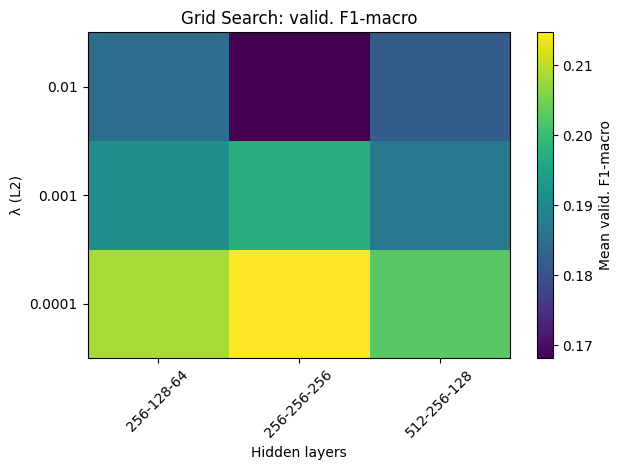

In [30]:
import numpy as np
import matplotlib.pyplot as plt

archs = sorted({k[0] for k in grid_results})
l2s   = sorted({k[1] for k in grid_results})
heat  = np.zeros((len(l2s), len(archs)))

for i, l2 in enumerate(l2s):
    for j, arch in enumerate(archs):
        heat[i, j] = grid_results[(arch, l2)]

plt.imshow(heat, origin='lower', aspect='auto')
plt.colorbar(label='Mean valid. F1-macro')
plt.xticks(np.arange(len(archs)), archs, rotation=45)
plt.yticks(np.arange(len(l2s)), l2s)
plt.xlabel('Hidden layers')
plt.ylabel('λ (L2)')
plt.title('Grid Search: valid. F1-macro')
plt.tight_layout()
plt.show()
